In [2]:
#These are the libraries you can use.  You may add any libraries directy related to threading if this is a direction
#you wish to go (this is not from the course, so it's entirely on you if you wish to use threading).  Any
#further libraries you wish to use you must email me, james@uwaterloo.ca, for permission.

from IPython.display import display, Math, Latex
import pandas as pd
import numpy as np
import numpy_financial as npf
import yfinance as yf
import matplotlib.pyplot as plt
import random
from datetime import datetime
import scipy as sp 
from scipy.optimize import minimize
import itertools as itr
from threading import Thread

## Group Assignment
### Team Number: 15
### Team Member Names: Neil Zhang, Rahim Rehan, Krish Patel
### Team Strategy Chosen: Risk-Free 

# Input Filtering
The following code will read in `Tickers.csv` and then perform filtration. The primary goal is to remove any duplicate tickers, any non US or Canadian companies, and any stocks that don’t trade at least 5000 shares between Oct 1, 2024 and Sep 30, 2025. 


## Preliminary Filtering
Using the `valid_tickers` function we can do a preliminary filtration by:

- Using `pandas` to read in the csv and then drop any duplicates tickers
- Downloading all the ticker information using `yfinance.download`. We will be using the period of Oct 1, 2024 to Oct 1, 2024 as finance excludes the last day
- Manipulating the dataframe to remove any months that trade less than 18 days, and removing stocks that don’t meet our volume requirement 

In [3]:
def valid_tickers(csv_file_path):
   """
   valid_tickers is the prelimary checker, it reads a csv and then removes any tickers that trade less than 5000 shares a month

   :param csv_file_path: A string that represents the csv file name that will be read
   :return: A list of names of the valid tickers
   """
   tickers_df = pd.read_csv(csv_file_path, header=None)
   tickers_df.drop_duplicates(inplace=True)
   tickers_df.columns = ["Ticker"]
   ticker_list = tickers_df["Ticker"].tolist()

   # Bulk download the ticker information
   hist = yf.download(
       tickers=ticker_list,
       start="2024-10-01",
       end="2025-10-01",
       group_by="ticker",
       auto_adjust=False,
       threads=True
    )
   
   # Count the rows per month per ticker
   counts = hist.groupby(hist.index.to_period("M")).transform("count")

   # Keep only rows where all tickers in that month have >= 18 trading days
   valid_days = counts >= 18

   # Remove the months that do not meet threshold and any tickers that don't have a large enough trading volume
   hist_filtered = hist[valid_days]
   vol_filtered = hist_filtered.xs("Volume", axis=1, level=1)
   avg_vol_filtered = vol_filtered.mean()
   valid_tickers = avg_vol_filtered[avg_vol_filtered >= 5000].index.tolist()

   return valid_tickers



## Secondary Filtering: Threaded
Now that we have a list of tickers that have passed our preliminary filtering, we want to remove any non US or Canadian companies. 

But since we need to use yfinance's `info` function, this process will be incredibly slow. Thus to reduce runtime we have decided to thread the secondary filtering, which is:

- Using `info` to get the `Currency` of a stock and if it isn’t traded in `CAD` or `USD` then return `NaN`
- We keep track of each valid ticker’s `Currency`, `Sector`, and `MarketCap`, all information that will be useful later

In the end we turn this information into a final `Dataframe` which is returned. 

In [4]:
#Begin threading set up
def get_format_info(ticker, ticker_data):
   """
   get_format_info is the threading worker function, it is what will be done in parallel. It finds wanted ticker info
   and adds it to a list

   :param ticker: The ticker whose info is wanted
   :param ticker_data: A list that keeps track of the ticker info thats been extracted
   """
   ticker_info = yf.Ticker(ticker).info

   # Get the currency, recall we only want USD and CAD traded stocks
   currency = ticker_info.get("currency")
   if (currency not in ["USD", "CAD"]):
      currency = "NaN"

   ticker_data.append((ticker, ticker_info.get("sector"), currency, ticker_info.get("marketCap")))

#Threading occurs
def format_tickers(csv_file_path):
   """
   format_tickers is the main function that performs threading onto the worker function and gets the dataframe of tickers and wanted info

   :param csv_file_path: A string that represents the csv file name that will be read
   :return: A Dataframe that contains all the info we want for every valid ticker
   """
   ticker_list = valid_tickers(csv_file_path)
   
   # Threading set up, ticker_data is the shared list where threads store their results, threads is the list of the thread objects
   ticker_data = []
   threads = []

   # Loop and create threads of each ticker in the ticker_list
   for t in ticker_list:
      thread = Thread(target=get_format_info, args=(t, ticker_data))
      threads.append(thread)
      thread.start()

   # Once all threads complete, join them together 
   for th in threads:
      th.join()

   # Create and clean up the Dataframe
   ticker_df = pd.DataFrame(ticker_data, columns=["Ticker","Sector","Currency","MarketCap"]) 
   ticker_df = ticker_df[ticker_df["Currency"] != "NaN"]
   ticker_df = ticker_df.reset_index(drop=True)
   return ticker_df

# Info Extraction
Now armed with the valid tickers, info extraction can be done. The most important thing to consider are the price movements of each stock, but since the period that will be considered is quite long, keeping track of daily data is both memory-intensive and not properly representative. What’s more important is how stocks behave **week by week**. 

The code below will find the weekly prices and weekly price percent changes of each stock. Using that information the following information can be obtained: `Variance`, `Standard Deviation`,  `Covariance Matrix`, and `Correlation Matrix`,

Recall that our strategy is to obtain a ***Risk-Free Portfolio***, which means we want a portfolio whose value does not move. In other words, absolutely no volatility, absolutely no concentration, absolutely no risk, and complete diversification. Those 4 metrics will help it comes to crafting such a portfolio as:

- `Variance` tells us how volatile a stock’s returns are from its mean return
- `Standard Deviation` also tells us how volatile a stock is
- A `Covariance Matrix` tells us how the variance between two assets correlate, giving us information on how to match different stocks together to minimize volatility
- A `Correlation Matrix` shows the strength of the relationship between two assets movements 

In [5]:
returns_start = "2024-11-14"
returns_end = "2025-11-14"

# Function to return a list of all tickers (first column elements)
def get_ticker_list (tickers_df):
     """
     get_ticker_list returns a Python list of tickers

     :param tickers_df: A Dataframe of tickers
     :return: A list of tickers
     """
     return tickers_df.iloc[:, 0].tolist()

# Gets weekly closes of all the stocks in a list of tickers
def get_weekly_closes (ticker_lst, start_date, end_date):
    """     
    get_weekly_closes performs data extraction to get weekly closing price info of stocks

    :param ticker_lst: List that holds all tickers
    :param start_date: start date for calculations
    :param end_date: end date for calculations
    :return: returns a Dataframe that holds the weekly closing price of each ticker on every week
    """
    #Define a dataframe to hold weekly close prices (checks every friday)
    cols = [] # list of Series to concat
    #Extract the weekly close prices and store them in the dataframe
    for i in ticker_lst:
        ticker = yf.Ticker(i)
        data = ticker.history(start=start_date, end=end_date)
        data.index = pd.to_datetime(data.index) # ensure datetime index
        #last() takes the last trading price of the week
        series = data['Close'].resample('W-FRI').last()
        series.name = f"Close {i}" # name each column
        cols.append(series) # store weekly closes for each ticker
        
    # Concatenate all ticker series at once to avoid fragmentation
    weekly_closes = pd.concat(cols, axis=1)
    # Strip time
    weekly_closes.index = weekly_closes.index.strftime('%Y-%m-%d')
    return weekly_closes

# Creates a df with the (weekly) %change for each column
def get_percent_change (closes, start_date, end_date):
    """     
    get_percent_change performs calculations that determines the percent change of closing prices

    :param closes: Dataframe that holds closing prices
    :param start_date: start date for calculations
    :param end_date: end date for calculations
    :return: returns a Dataframe that holds percent changes of closing prices
    """
    cols = [] # list of Series to concat
    
    for i in closes:
        col_name = i[6:] # name each column by the ticker from "Close ---"
        # calculate %change
        series = closes[i].pct_change(fill_method=None) # Fill_method=None to hande delisted stocks
        series.name = f"% Change {col_name}" # name each column
        cols.append(series) # store %change for each ticker

    # Concatenate all ticker series at once to avoid fragmentation
    percent_change = pd.concat(cols, axis=1)
    return percent_change

# Calculate covariance, correlation, variance, standard deviation
def get_calculations(ticker_list, start_date, end_date):
    """     
    get_calculations performs calculations for covariance, correlation, variance, standard deviation

    :param ticker_list: list of all tickers
    :param start_date: start date for calculations
    :param end_date: end date for calculations
    :return: returns a dictionary that holds covariance, correlation, standard deviation, and variance 
    """
    weekly_closes = get_weekly_closes(ticker_list, start_date, end_date)
    weekly_percent_change = get_percent_change(weekly_closes, start_date, end_date)
    covariance_matrix = {
        'Covariance': weekly_percent_change.cov(),
        'Correlation': weekly_percent_change.corr(),
        'Variance': weekly_percent_change.var(),
        'Std_Dev': weekly_percent_change.std()}
    return covariance_matrix

info_df = format_tickers("Extended_Tickers_Example.csv") #NOTE: CHANGE FILE NAME BEFORE SUBMITTING
ticker_list = (get_ticker_list(info_df)) # List of all tickers
primary_calculations = get_calculations(ticker_list, returns_start, returns_end) # Covariance matrix
"""
# Access each piece like:
display(primary_calculations['Covariance'])
display(primary_calculations['Std_Dev'])
"""

[*********************100%***********************]  143 of 143 completed

10 Failed downloads:
['PTR', 'MON', 'RTN', 'CELG', 'BRK.B', 'GIB.A.TO', 'DFS', 'ZZZ.TO', 'ATVI', 'AGN']: YFTzMissingError('possibly delisted; no timezone found')


"\n# Access each piece like:\ndisplay(primary_calculations['Covariance'])\ndisplay(primary_calculations['Std_Dev'])\n"

# Portfolio Variance
Our chosen strategy is to create a ***Risk-Free Portfolio***, but what does that mean? In academic terms a risk free asset has:
$$
\sigma^2  = 0 
$$
Meaning its return is constant and guaranteed, with no random variation. Thus a ***Risk-Free Portfolio*** needs a variance of 0. 

While finding the variation of a singular asset is simple, a portfolio's variance is much harder. After all, different assets clash and diversification will play a part in reducing variance. 

Now we could implement a method that finds the percent returns of the entire portfolio and then calculates its variance, but such a method is lengthy and difficult to mathematically optimize. Thankfully, there exists a formula that calculates a portfolio’s variance:

$$
\sigma_p^2 = \sum_{i=1}^{n} \sum_{j=1}^{n} w_i w_j \sigma_{ij}
$$

Where w_i, w_j are the weights of assets and \sigma_{ij} is the covariance. This formula can also be rewritten for matrix calculations (which we want):

$$
\sigma_p^2 = \quad w^T \Sigma w
$$

Where w represents the weight of each asset and $\Sigma$ is a 2D matrix that holds the covariance between each asset. 

By using that variance formula, we can determine the variance of a portfolio without needing to find the value of the portfolio first. The following code is a function that implements this formula. 

In [6]:
# This is the function we want to minimize, aka the minimum variance function
def port_variance(weights, cov_matrix):
    """     
    port_variance is the function that calculates the variance of a portfolio. It performs 
    dot product/matrix multiplication on the weights and covariance matrixes. 

    :param weights: an array that represents the weight of each asset
    :param cov_matrix: a 2D matrix that represents the covariance between each asset 
    :return: variance of the portfolio
    """
    weights_col = weights.reshape(-1, 1) # Turns into column vector
    port_var = np.dot(weights_col.transpose(), (np.dot(cov_matrix, weights_col))) # Doing dot product 
    return port_var[0][0]

# Finding Risk-Free: How Do We Minimum Variance?
Getting a variance of 0 is realistically not possible, but what is possible is minimizing variance. Our goal is to create a portfolio with the smallest possible variance. 

The most obvious way we can do that is find the lowest variance after constructing every single possible portfolio of 10-25 assets from our `N` tickers. But such a task would require too much computation. 
- With only 50 stocks, there would be over `1.027x10^10` ways to form a portfolio of just 10 assets 
We need a smarter method. 

A smarter method is using a ranking approach. 
- Every valid stock is ranked on how much they can help with minimizing a portfolio’s variance
- Then we can create `15` portfolios that hold the top 10, 11, 12…, 25 etc, most impactful stocks 
- Then find the lowest variance portfolio of those 15 portfolios

This method is significantly more efficient, as we no longer have to compute the variance of `>1.027x10^10` portfolios and instead just `15`.

## Ranking Approach

But there lies an issue. 
- How do we rank the impactfulness of a stock on minimizing variance? 
- Base it on a stock’s `Variance`? But then what if it has unwanted correlations? 
- What if we choose `Covariance`, or `Correlation`, or maybe we all 3. But then how do we determine which metric is more important than the others? 

So rather than trying to base a stock’s impactfulness on a metric, let's go straight to what we really want: minimum variance and its correlated `weightings`. After all, higher weighting imply more impactfulness. 

### Primary Optimization
We can rank a stock’s impactfulness on minimizing variance by turning our port_variance function into an optimization problem using `SciPy`. 

If we give port_variance the covariance matrix of all `N` valid tickers and not their weightings, it will return the minimum variance and the optimized weightings. 

Now by sorting through these weightings from highest to lowest, we have now ranked the impactfulness. The higher the weighting of an asset, the more important it was to minimizing variance.

The following function performs this primary optimization (though it doesn’t do the sort just yet).

In [7]:
# Primary minimization, there is bounds in this 
def primary_minimization(cov_matrix):
    """     
    primary_minimization is the function that finds the weightings that result in the mimimum variance. 
    It performs this using scipy optimization. This perimary version does not consider bounds. 

    :param cov_matrix: a 2D matrix that represents the covariance between each asset 
    :return: returns the minimum variance and the weightings associated with that
    """
    num_assets = cov_matrix.shape[0]
    initial_weight = [1/num_assets] * num_assets # The initial guess of the weights

    constraint = {
        'type':'eq', # Constraint type is equality
        'fun': lambda w: sum(w) - 1 # The function's weight's must sum to 1
        }
    
    weight_bounds = [(0, 1)] * num_assets # Does not allow short selling
    
    # Finds the resilt of the minimization of the port_variance function, using the initial guess, keeping the cov_matrix constant using the SLSQP method, and with the above listed constraint
    result = minimize(fun=port_variance, x0=initial_weight, args=(cov_matrix,), method='SLSQP', bounds=weight_bounds, constraints=constraint)
    return result.fun, result.x

pd_cov_matrix = primary_calculations['Covariance']
numpy_cov_matrix = pd_cov_matrix.to_numpy() # Matrix of covariances of assets
primary_var, primary_weights = primary_minimization(numpy_cov_matrix)

### Secondary Optimization
Now with the Primary Optimization, we can create a Secondary Optimization model that properly optimizes a portfolio to respect weighting bounds. With `SciPy` we can establish `min_weight` and `max_weight` of assets. Now no asset can be more than 15% and none below (100/2n)% where `n` represents the number of stocks. 

The following function performs this secondary optimization. 

In [8]:
# The secondary optimization that includes the bounds 
def secondary_minimization(cov_matrix):
    """     
    secondary_minimization is the function that finds the weightings that result in the mimimum variance while considering the bounds.
    That is, it ensures the weightings 

    :param cov_matrix: a 2D matrix that represents the covariance between each asset 
    :return: returns the minimum variance and the weightings associated with that
    """
    num_assets = len(cov_matrix[0]) 
    initial_weight = [1/num_assets] * num_assets # The initial guess of the weights

    min_weight = (100/(2*num_assets))/100 # Do not need to include portfolio value, because 1 is the portfolio value (and sum of weights)
    max_weight = 0.15 # Same as above

    constraint = {
        'type':'eq', # Constraint type is equality
        'fun': lambda w: sum(w) - 1 # The function's weight's must sum to 1
        }
    
    weight_bounds = [(min_weight, max_weight)] * num_assets
    
    # Finds the resilt of the minimization of the port_variance function, using the initial guess, keeping the cov_matrix constant using the SLSQP method, and with the above listed constraint
    result = minimize(fun=port_variance, x0=initial_weight, args=(cov_matrix,), method='SLSQP', bounds = weight_bounds, constraints=constraint)
    return result.fun, result.x

# Ranking Approach: Creating Portfolios
With all `N` tickers properly ranked from most to least important, we can start creating the 15 portfolios that hold the 10 to 25 most impactful stocks. 

However building our 15 portfolios. Each portfolio must contain a `large cap` and a `small cap` company. 

So when we’re building our portfolio we’re constantly checking if these conditions will be fulfilled. If they’re not then the function tries its best to fulfill them. 

For example when building a portfolio of size 15, if there is not a `small cap` company in the top 15 but the 16th most important stock is `small cap` then it will build a portfolio with the Rank 16 stock rather than the Rank 15. 

To put it simply, the `Least Impactful` stock(s) will always be replaced if needed in order to make the portfolio valid. Even if that goes against the Ranking order. 

In [9]:
# Code that creates a portfolio that matches the requirements

# Determines all the indexes in a portfolio that are large cap stocks
def is_lg_cap(portfolio):
    """
     is_lg_cap determines all the indexes in a portfolio that are large cap stocks

     :param portfolio: A list of Series objects that contain a stock's info 
     :return: A list of indexes of ticker's that are large cap
     """
    lg_cap = []
    for i in range(len(portfolio)):
        if portfolio[i]['MarketCap'] > 10_000_000_000:
            lg_cap.append(i)
    return lg_cap

# Determines all the indexes in a portfolio that are small cap stocks
def is_sm_cap(portfolio):
    """
     is_sm_cap determines all the indexes in a portfolio that are small cap stocks

     :param portfolio: A list of Series objects that contain a stock's info 
     :return: A list of indexes of ticker's that are small cap
     """
    sm_cap = []
    for i in range(len(portfolio)):
        if portfolio[i]['MarketCap'] < 2_000_000_000:
            sm_cap.append(i)
    return sm_cap

# Determines if an individual stock is a large market cap
def is_lg(row):
    return row['MarketCap'] > 10_000_000_000

# Determines if an individual stock is a small market cap
def is_sm(row):
    return row['MarketCap'] < 2_000_000_000

# Determines the index of the least important stock. Least important in this case is the one with the lowest weighting in the ordered list, but
# if the least important is either the ONLY SMALL or LARGE cap stock then the second least important stock is now designated the least important
def find_least_imp(portfolio, lg_indxs, sm_indxs):
    """ 
    find_least_imp Determines the index of the least important stock. Least important in this case is the one with the lowest weighting in the ordered list, but 
    if the least important is either the ONLY SMALL or LARGE cap stock then the second least important stock is now designated the least important

    :param portfolio: A list of stock data in Series format
    :param lg_indxs: A list of all indexes that hold large cap stocks
    :param sm_indxs: A list of all indexes that hold small cap stocks
    :return: integer that represents the index that is desginated least important
    """

    only_large_idx = None
    only_small_idx = None

    # Determines the protected indexes
    if len(lg_indxs) == 1:
        only_large_idx = lg_indxs[0]
    if len(sm_indxs) == 1:
        only_small_idx = sm_indxs[0]

    for i in range(len(portfolio) - 1, -1, -1):
        if i != only_large_idx and i != only_small_idx:
            return i

def valid_port_check(ticker_list):
    """
    valid_port_check checks if a portfolio fits all sector and weighting constraints

    :param ticker_list: A list of ticker names
    :return: Boolean value depending on if its true or not
    """
    portfolio = [] # Will be a list of Series
    port_sectors = []
    max_sector_num = int(len(ticker_list) * 0.4)

    # Creates preliminary portfolio 
    for i in range(len(ticker_list)):
        cur = ordered_info_df[ordered_info_df["Ticker"] == ticker_list[i]].iloc[0]
        cur_sector = cur['Sector']
        portfolio.append(cur)
        port_sectors.append(cur_sector)
    
    for s in port_sectors:
        if ((port_sectors.count(s)) > max_sector_num):
            return False

    num_lg = len(is_lg_cap(portfolio))
    num_sm = len(is_sm_cap(portfolio))
    if (num_lg == 0 or num_sm == 0):  
        return False
    
    return True


# Creates a portfolio that is valid, aside from the 40% sector restriction
def create_portfolio(size):
    """ 
    create_portfolio creates a portfolio containing both small and large cap

    :param size: the size of the portfolio
    :return: a list of tickers that are in the portfolio, or none if it cannot create a portfolio that satisfies all requirements
    """

    portfolio = [] # Will be a list of Series
    i = 0
    ticker_only = []
    
    # Creates preliminary portfolio 
    while len(portfolio) < size:
        if i >= len(ordered_info_df):
            return None
        cur = ordered_info_df.iloc[i]
        portfolio.append(cur)
        i += 1

    lg_idxs = is_lg_cap(portfolio)
    sm_idxs = is_sm_cap(portfolio)

    # Fixes the no large market cap issue
    while len(lg_idxs) == 0: 
        replaced = find_least_imp(portfolio, lg_idxs, sm_idxs)
        if i >= len(ordered_info_df):
            return None
        cur = ordered_info_df.iloc[i]
        
        if (is_lg(cur)):
            portfolio[replaced] = cur

        lg_idxs = is_lg_cap(portfolio)
        sm_idxs = is_sm_cap(portfolio)
        i += 1

    # Fixes the no small market cap issues
    while len(sm_idxs) == 0: 
        replaced = find_least_imp(portfolio, lg_idxs, sm_idxs)
        if i >= len(ordered_info_df):
            return None
        cur = ordered_info_df.iloc[i]
        
        if (is_sm(cur)):
            portfolio[replaced] = cur
        lg_idxs = is_lg_cap(portfolio)
        sm_idxs = is_sm_cap(portfolio)
        i += 1
    
    for stock in portfolio:
        ticker_name = stock["Ticker"]
        ticker_only.append(ticker_name)
    
    return ticker_only

# Sector Limits

One extremely important restriction in our portfolio is that no sector can be worth more than 40% of the portfolio's value. However there is a problem, to see if a sector is worth more than 40% we must first know the weights of each stock. That means we have to run the secondary optimization **before** checking the sector limits. 

We have to perform a two-stage optimization. 

After running secondary optimization we check if any sector limits are broken, if they are we go and replace the least important stock in the heaviest sector with a replacement. Then we check again if this replacement has fulfilled the sector limit. 

In [10]:
def compute_sector_weights(tickers, weights, info_df):
    """
    Calculate how much of the portfolio, by weight, belongs to each sector.
    :param tickers: list of ticker names 
    :param weights: list of weights from the optimizer 
    :param info_df: dataframe that includes Ticker and Sector columns
    :return: the sector weight total
    """

    # Make lookup by ticker
    info_by_ticker = info_df.set_index("Ticker")

    sector_totals = {}  # Holds sum of weights for each sector

    # Loop through
    for ticker, wt in zip(tickers, weights):
        sector = info_by_ticker.loc[ticker, "Sector"]
        
        # Add weight to appropriate sector
        if sector not in sector_totals:
            sector_totals[sector] = 0.0
        sector_totals[sector] += float(wt)

    return sector_totals

def optimize_with_sector_limit(initial_tickers, returns_start, returns_end, info_df):
    """
    optimize_with_sector_limit will run optimization and enforce 40% sector-by-value constraint by replacing the
    smallest-weight stock in the overweight sector until constraints are satisfied or no replacements are possible
    :param initial_tickers: The list of ticker symbols that is the starting portfolio before optimization
    :param returns_start: A date
    :param returns_end: A date
    :param info_df: A DataFrame containing the Ticker and Sector columns, in our case its gonna be ordered_info_df
    """

    current_tickers = list(initial_tickers)
    used_tickers = set(current_tickers)

    # Maximum range is 20, only go through 20 iterations before stopping to prevent runtime loss
    for n in range(20):
        # Get values needed for secondary optimization
        calc_df = get_calculations(current_tickers, returns_start, returns_end)
        cov_np = calc_df["Covariance"].to_numpy()

        portfolio_variance, weights = secondary_minimization(cov_np)
        weights = np.array(weights).flatten() 

        # Get each sectors weights
        sector_weights = compute_sector_weights(current_tickers, weights, info_df)

        # Find the sector with the largest weight, if this one is valid that all others are valid
        heaviest_sector = None
        heaviest_weight = -1.0
        for sector, w in sector_weights.items():
            if w > heaviest_weight:
                heaviest_sector = sector
                heaviest_weight = w

        # Check if the heaviest weight is under the max, if so return the information
        if heaviest_weight <= 0.4:
            return current_tickers, portfolio_variance, weights

        # Find the least weighted, aka least important, stock of the heaviest sector
        info_indexed = info_df.set_index("Ticker")

        smallest_weight = 100000 # Placeholder
        smallest_index = None

        for i in range(len(current_tickers)):
            sector_name = info_indexed.at[current_tickers[i], "Sector"]
            if sector_name == heaviest_sector:
                if weights[i] < smallest_weight:
                    smallest_weight = weights[i]
                    smallest_index = i

        # Get a replacement ticker to replace the least important heaviest sector 
        replacement_ticker = None
        for row in info_df.itertuples(index=False):
            candidate = row.Ticker
            if candidate not in used_tickers:
                replacement_ticker = candidate
                break

        # If no new ticker available then stop trying to fix portfolio
        if replacement_ticker is None:
            return None, None, None

        # Replace smallest-weight stock in overweight sector
        used_tickers.add(replacement_ticker)
        current_tickers[smallest_index] = replacement_ticker

    # End loop fallback once we go over iterations
    return None, None, None

# Result

The following code puts this all together. Runs the primary optimization and then creates the 15 portfolios, and then determines which one results in the smallest variance using the secondary optimization whilst ensuring it satisfies all restrictions (including sector).


In [11]:
info_df['weight'] = primary_weights #Assume info_df holds the tickers, sector, market cap, etc and not the dates etc. We now add the weights.
ordered_info_df = info_df.copy().sort_values('weight', ascending = False).reset_index(drop=True)

ordered_info_df

all_ports = []
all_variance = []
all_weights = []
count = 0
while (count + 10) < 26:

    size = count + 10
    base_port = create_portfolio(size)

    if base_port is None:
        print(f"Failed to build portfolio of size {count+10}, skipping.")
        count += 1
        continue

    final_port, final_var, final_w = optimize_with_sector_limit(base_port, returns_start, returns_end, ordered_info_df)
    if final_port is None:
        print(f"Sector constraint failed for portfolio size {count+10}, skipping.")
        count += 1
        continue

    all_ports.append(final_port)
    all_variance.append(final_var)
    all_weights.append(final_w)
    count += 1

if not all_variance:
    print("No valid portfolios were generated for some reason. Please check ticker csv.")
else:
    smallest_var = min(all_variance)
    index = all_variance.index(smallest_var)
    target = [smallest_var, all_ports[index], all_weights[index]]
    print(f"The smallest variance found is {target[0]} which is determined from the following portfolio: {target[1]}, at the following weights {target[2]}.")

The smallest variance found is 7.889822364510392e-05 which is determined from the following portfolio: ['DG', 'FTS.TO', 'CME', 'DUK', 'AEP', 'EXC', 'ENB.TO', 'WN.TO', 'BNS.TO', 'UL', 'BB.TO', 'BTI', 'LMT', 'KO', 'T.TO', 'SLF.TO', 'BCE.TO', 'COST', 'ATD.TO', 'TRP.TO', 'GOOG', 'WCN.TO', 'RY.TO', 'NA.TO', 'KITS.TO'], at the following weights [0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04
 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04 0.04].


# Purchasing Shares

Using the weightings of the minimized variance, it purchases stocks at a specific day's closing price at those weights. 

When purchasing we consider two fee methods, one where we pay a flat $2.15 USD fee, and another where each share costs $0.001 USD (note we convert all our calculations and prices into CAD). 

We perform both of these methods, and choose the method that lets us spend the closest to our target budget of $1,000,000 CAD. 

In [12]:
def get_close_prices_and_rate(tickers, target_date, end_date):
    """
    get_close_prices_and_rate finds the closing price of tickers on a date, and the exchange rate on a date

    :param tickers: list of tickers
    :param target_data: the day of price we want, normally most recent business day
    :param end_date: the day after, as yfinance is not inclusive
    :return: a Series that contains the target days close price
    :return: the USD to CAD exchange rate
    """
    data = yf.download(tickers, start=target_date, end=end_date)["Close"]
    close_prices = data.iloc[0]

    exchange_rate = yf.download("CAD=X", start=target_date, end=end_date)["Close"]
    exchange_rate = exchange_rate.iloc[0]

    return close_prices, exchange_rate.item()

def purchase_flat_fee(df, budget, exchange_rate):
    """
    purchase_flat_fee transforms a Dataframe to include the amount of shares bought with a flat fee, and the value of that

    :param df: The Dataframe that will be transformed
    :param budget: An Integer representing the budget
    :param exchange_rate: A series of the USD-CAD exchange rate
    :return: Transformed Dataframe
    """

    df["Shares Bought Flat Fee"] = (df["Weight"] * (budget - (2.5*exchange_rate))) / df["Price"]
    df["Flat Fee Worth"] = df["Shares Bought Flat Fee"] * df["Price"]

    return df 

def purchase_variable_fee(df, budget, exchange_rate):
    """
    purchase_variable_fee transforms a Dataframe to include the amount of shares bought with the share-dependent rate

    :param df: The Dataframe that will be transformed
    :param budget: An Integer representing the budget
    :param exchange_rate: A series of the USD-CAD exchange rate
    :return: Transformed Dataframe
    """
    df["Shares w/o Fee"] = (df["Weight"] * budget) / df["Price"]
    total_shares = df["Shares w/o Fee"].sum()
    
    variable_fee_usd = total_shares * 0.001
    variable_fee_cad = variable_fee_usd * exchange_rate

    adjusted_budget = budget - variable_fee_cad
    df["Shares Bought Variable Fee"] = (df["Weight"] * adjusted_budget) / df["Price"]
    df["Variable Fee Worth"] = df["Shares Bought Variable Fee"] * df["Price"]

    return df

def ideal_shares(df):
    """ 
    ideal_shares determines which fee strategy, flat or variable, is the most optimal and transforms Dataframe accordingly

    :param df: The Dataframe that will be transformed
    :return: Transformed Dataframe
    """
    sum_flat_fee = df["Flat Fee Worth"].sum()
    sum_variable_fee = df["Variable Fee Worth"].sum()

    if (sum_flat_fee < sum_variable_fee):
        df.drop(["Shares Bought Flat Fee", "Flat Fee Worth", "Shares w/o Fee"], axis=1, inplace=True)
        df.rename(columns={"Shares Bought Variable Fee":"Shares", "Variable Fee Worth":"Value"}, inplace=True)
    else:
        df.drop(["Shares Bought Variable Fee", "Variable Fee Worth", "Shares w/o Fee"], axis=1, inplace=True)
        df.rename(columns={"Shares Bought Flat Fee":"Shares", "Flat Fee Worth":"Value"}, inplace=True)
    
    return df 

def add_currency(df_small, df_large):
    """ 
    add_currency adds the currency type onto the Dataframe

    :param df_small: The Dataframe that holds the shares bought
    :param_df_large: The Dataframe the holds the Currency's
    :return: Transformed Dataframe
    """

    df_with_currency = df_small.merge(df_large[["Ticker", "Currency"]], on="Ticker", how="left")
    return df_with_currency

def convert_closing(df, exchange_rate):
    """
    convert_closing converts the price of any stock thats in USD to CAD

    :param df: Dataframe to be transformed
    :param exchange_rate: The USD-CAD rate
    :return: Dataframe with converted prices
    """

    df.loc[df["Currency"] == "USD", "Price"] = df["Price"] * exchange_rate
    return df

# Create Final Dataframe Output 

In [13]:
temp_df = pd.DataFrame({
    "Ticker": target[1],
    "Weight": target[2]
})

target_date = "2025-11-18" #Example
end_date = "2025-11-19" #Example
closing, usd_cad_rate = get_close_prices_and_rate(target[1], target_date, end_date)
temp_df["Price"] = closing.to_numpy()
temp_df = add_currency(temp_df,ordered_info_df)
temp_df_cad = convert_closing(temp_df, usd_cad_rate)
temp_df_cad = purchase_flat_fee(temp_df_cad, 1_000_000, usd_cad_rate)
temp_df_cad = purchase_variable_fee(temp_df_cad, 1_000_000, usd_cad_rate)
Portfolio_Final = ideal_shares(temp_df_cad)
Portfolio_Final

/var/folders/t6/0pgnx1h16112t2cmg14zf9ph0000gn/T/ipykernel_5692/1056367655.py:11: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, start=target_date, end=end_date)["Close"]
[*********************100%***********************]  25 of 25 completed
/var/folders/t6/0pgnx1h16112t2cmg14zf9ph0000gn/T/ipykernel_5692/1056367655.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  exchange_rate = yf.download("CAD=X", start=target_date, end=end_date)["Close"]
[*********************100%***********************]  1 of 1 completed


,Ticker,Weight,Price,Currency,Shares,Value
0,DG,0.04,173.537733,USD,230.496611,39999.859495
1,FTS.TO,0.04,69.510002,CAD,575.454730,39999.859495
2,CME,0.04,8.458401,USD,4729.009479,39999.859495
3,DUK,0.04,45.256660,USD,883.844700,39999.859495
4,AEP,0.04,133.198748,USD,300.302068,39999.859495
5,EXC,0.04,77.081046,USD,518.932495,39999.859495
6,ENB.TO,0.04,279.279999,CAD,143.224934,39999.859495
7,WN.TO,0.04,895.080017,CAD,44.688585,39999.859495
8,BNS.TO,0.04,103.330002,CAD,387.107895,39999.859495
9,UL,0.04,173.945199,USD,229.956674,39999.859495


# Output Final CSV

In [14]:
Portfolio_Final[['Ticker', 'Shares']].to_csv("Stocks_Group_15.csv", index=False)

# Double Checking Weights, Shares, and Values

In [15]:
sum_weight = Portfolio_Final["Weight"].sum() # Doesn't return 1 properly because floats can't sum to exact integers
sum_shares = Portfolio_Final["Shares"].sum()
sum_value = Portfolio_Final["Value"].sum()
print(f"The sum of the weights is {sum_weight}, the sum of the shares is {sum_shares}, the sum of the values is {sum_value}.")

The sum of the weights is 1.0, the sum of the shares is 17500.606131598044, the sum of the values is 999996.4873749018.


In [16]:
# --- Third Optimization --- #

# Make a list of the top 30 most important stocks
ordered_ticker_list = get_ticker_list(ordered_info_df)
ordered_ticker_list = ordered_ticker_list[0:30]


def create_portfolio_combs(ticker_list):
    if not valid_port_check(ticker_list):
        return None, None, None
    else:
        temp_cov2 = get_calculations(ticker_list, returns_start, returns_end)
        cov_np2 = temp_cov2['Covariance'].to_numpy()
        temp_var2, temp_weights2 = secondary_minimization(cov_np2)

        # Returns the inputted list, the variance, and a list of the weights
        return ticker_list, temp_var2, temp_weights2


def create_optimal_portfolio(ordered_ticker_list):
    # Create list of every possible portfolio
    potential_portfolios = list(itr.combinations(ordered_ticker_list, 25))

    # Initialize the optimal portfolio data
    optimal_port = None
    optimal_var = float("inf")       # Infinitely high float
    optimal_weights = None

    for i in potential_portfolios:
        current_port, current_var, current_weights = create_portfolio_combs(i)

        # Current portfolio failed the requirements
        if current_port is None:
            continue # skip
        
        # If the current portfolio has a lower variance than any previous ones
        if current_var <= optimal_var:
            # Set the optimal portfolio data to the current
            optimal_port = current_port
            optimal_var = current_var
            optimal_weights = current_weights

    return optimal_port, optimal_var, optimal_weights


# optimal_portfolio, optimal_variance, optimal_weights = create_optimal_portfolio(ordered_ticker_list)


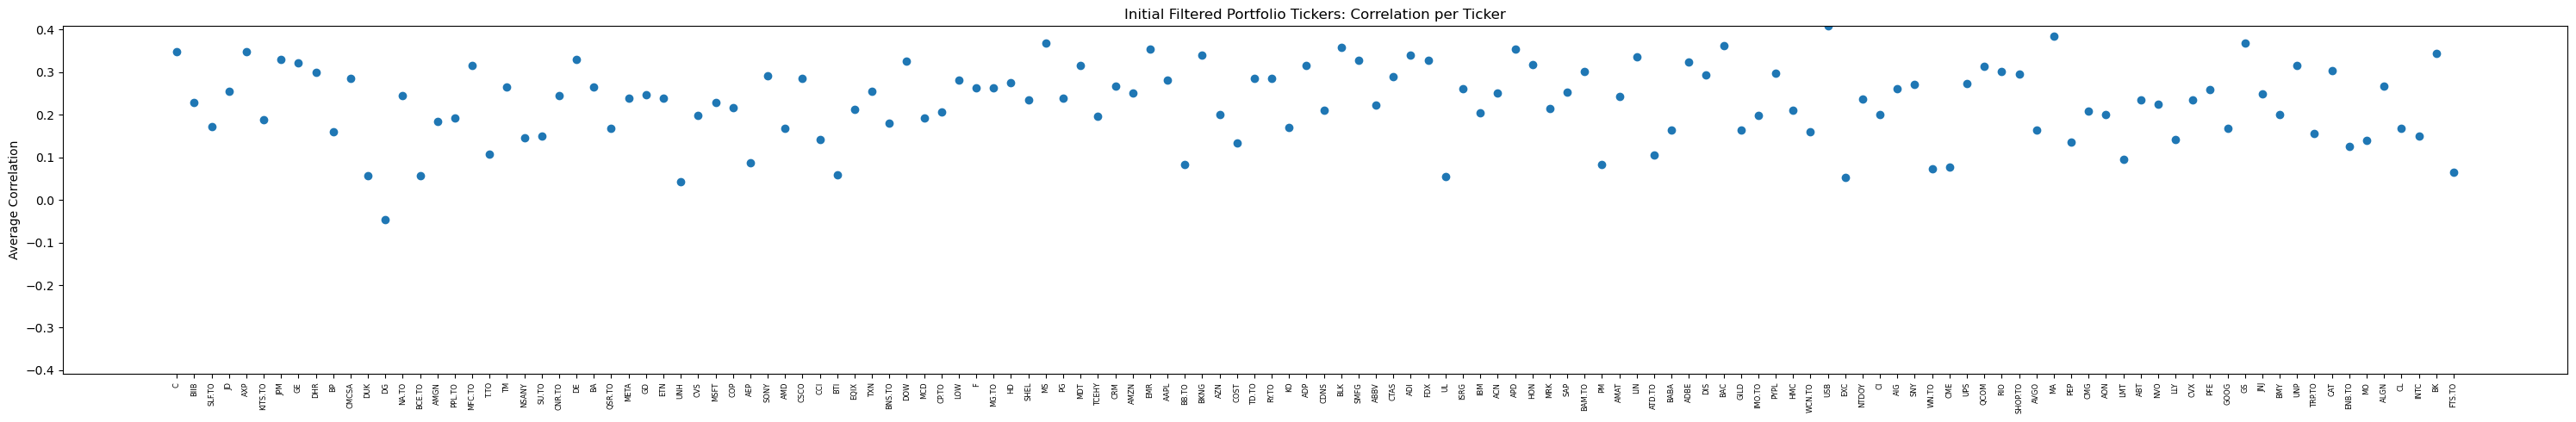

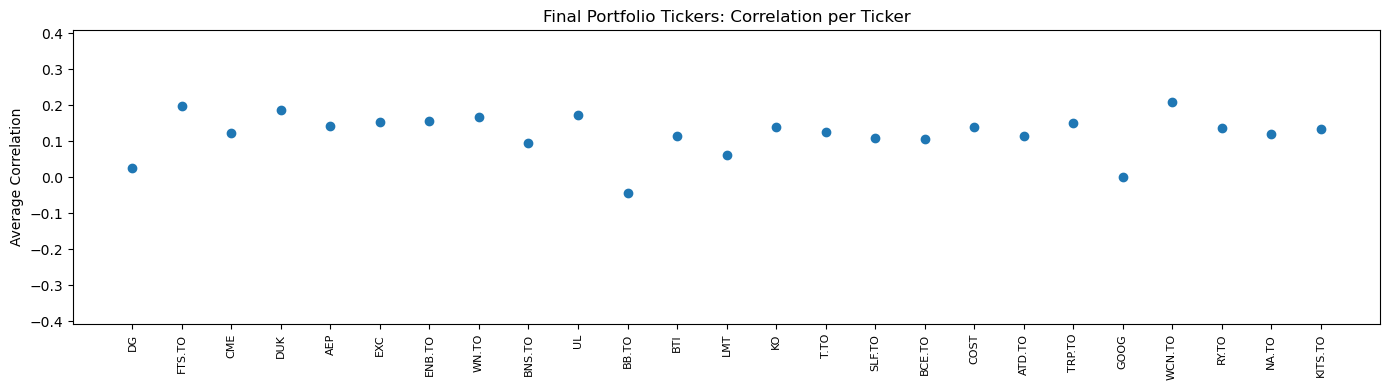

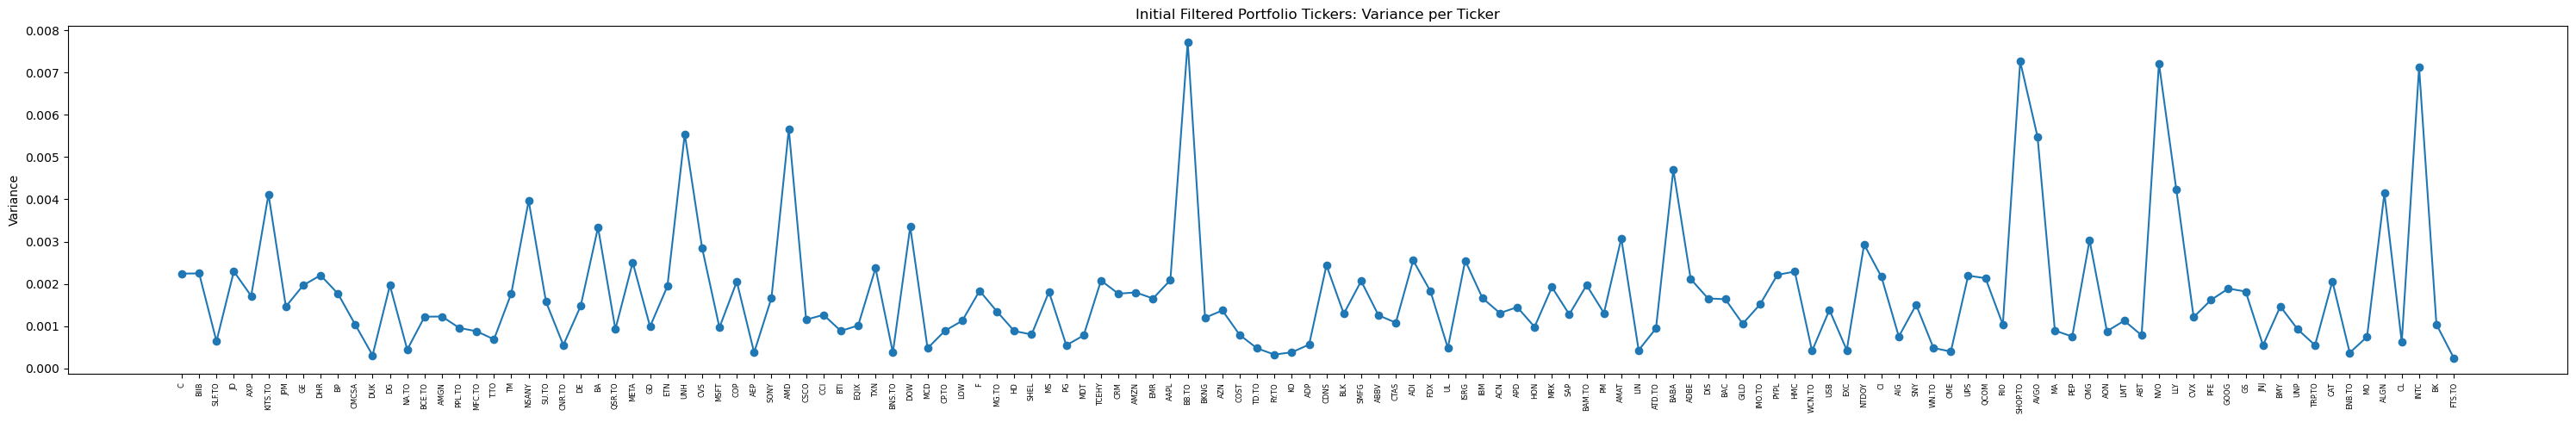

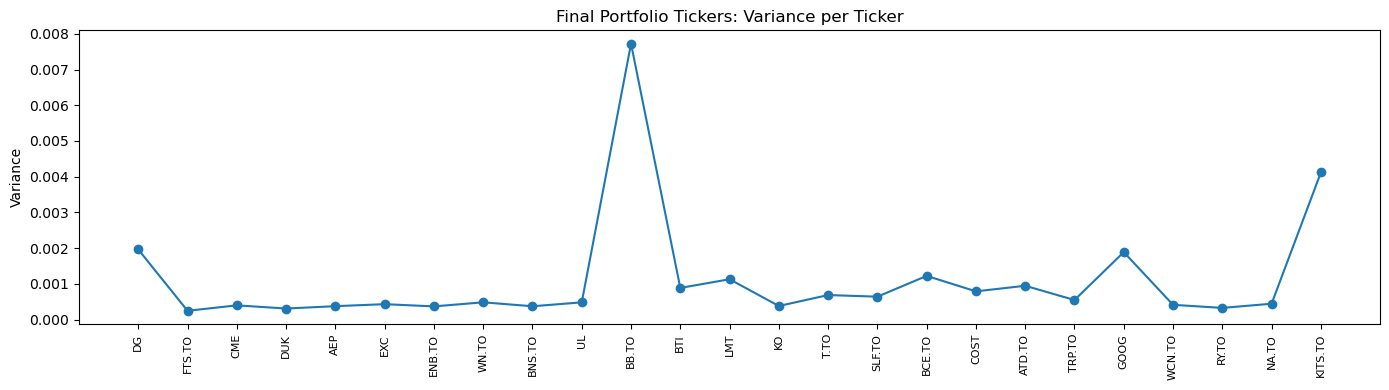

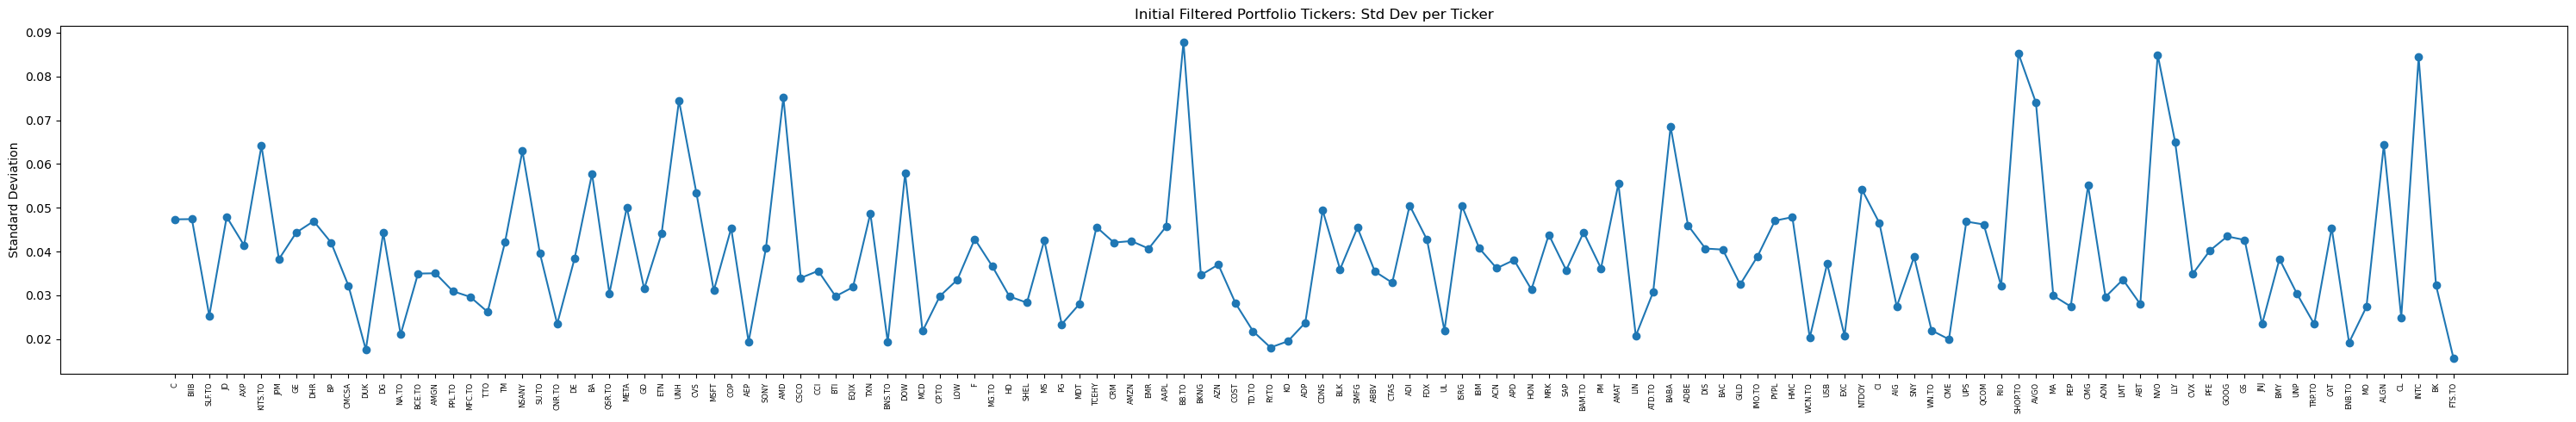

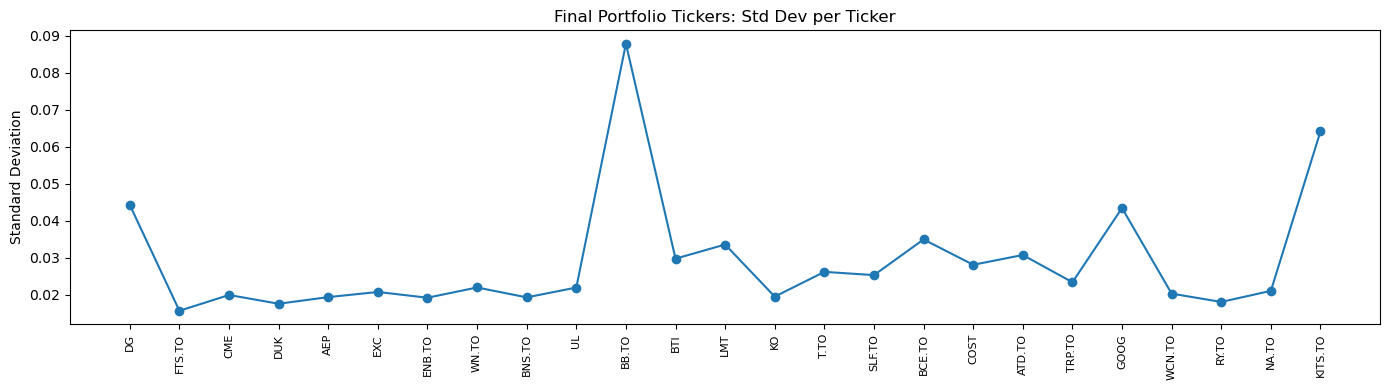

In [19]:
############# GRAPHS ###################

#Here im getting the metrics for the initial filtered portfolio tickers
filtered_metrics = primary_calculations

#Here im getting the metrics for the final portfolio tickers
final_portfolio_tickers = Portfolio_Final["Ticker"].tolist()

#Using previous funcion that we made to get the final portlfio metrics
final_metrics = get_calculations(final_portfolio_tickers, returns_start, returns_end)

# Remove the % Change prefix from each index label
def strip_prefix(index_obj):
    cleaned = []
    for name in index_obj:
        s = str(name)

        # % Change is 9 characters long so check first 9 characters only
        if len(s) > 9 and s[0:9] == "% Change ":
            s = s[9:]   #So here we drop the first 9 characters

        cleaned.append(s)
    return cleaned

#This function plot_metric_comparison will plot graphs for correlation, variance, and std dev for our inital filtered portfolio tickers vs final portfolio tickers
def plot_metric_comparison(filtered_metrics, final_metrics):

    #Here we are extracting metrics for the inital filtered portfolio tickers
    filtered_corr = filtered_metrics["Correlation"].mean(axis=1)
    filtered_var  = filtered_metrics["Variance"]
    filtered_std  = filtered_metrics["Std_Dev"]

    #Here we are cleaning ticker names for the inital filtered portfolio tickers (removing the %Change in the name as we want to make the x axis in our graphs only the ticker symbol)
    filtered_corr_tickers = strip_prefix(filtered_corr.index)
    filtered_var_tickers  = strip_prefix(filtered_var.index)
    filtered_std_tickers  = strip_prefix(filtered_std.index)

    #Here we are extracting metrics for the final portfolio tickers
    final_corr = final_metrics["Correlation"].mean(axis=1)
    final_var  = final_metrics["Variance"]
    final_std  = final_metrics["Std_Dev"]

    #Here we are cleaning ticker names for the final portfolio tickers (removing the %Change in the name as we want to make the x axis in our graphs only the ticker symbol)
    final_corr_tickers = strip_prefix(final_corr.index)
    final_var_tickers  = strip_prefix(final_var.index)
    final_std_tickers  = strip_prefix(final_std.index)

    
    ####### CORRELATION GRAPH #######
    
    #Here we are computing shared y-axis limits
    max_abs_corr = max(
        abs(filtered_corr.min()),
        abs(filtered_corr.max()),
        abs(final_corr.min()),
        abs(final_corr.max())
    )
    y_min = -max_abs_corr
    y_max =  max_abs_corr

    #Inital filtered portfolio tickers correlation graph
    plt.figure(figsize=(30,5))
    plt.scatter(filtered_corr_tickers, filtered_corr)
    plt.xticks(rotation=90, fontsize=6)
    plt.ylabel("Average Correlation")
    plt.title("Initial Filtered Portfolio Tickers: Correlation per Ticker")
    plt.ylim(y_min, y_max)   # <<< SAME Y AXIS
    plt.tight_layout()
    plt.show()

    #Final portfolio tickres correlation graph
    plt.figure(figsize=(14,4))
    plt.scatter(final_corr_tickers, final_corr)
    plt.xticks(rotation=90, fontsize=8)
    plt.ylabel("Average Correlation")
    plt.title("Final Portfolio Tickers: Correlation per Ticker")
    plt.ylim(y_min, y_max)   # <<< SAME Y AXIS
    plt.tight_layout()
    plt.show()

    ####### VARIANCE GRAPH #######
   
    #Inital filtered portfolio tickers variance graph
    plt.figure(figsize=(30,5))
    plt.plot(filtered_var_tickers, filtered_var.values, marker="o")
    plt.xticks(rotation=90, fontsize=6)
    plt.ylabel("Variance")
    plt.title("Initial Filtered Portfolio Tickers: Variance per Ticker")
    plt.tight_layout()
    plt.show()

    #Final portfolio tickres variance graph
    plt.figure(figsize=(14,4))
    plt.plot(final_var_tickers, final_var.values, marker="o")
    plt.xticks(rotation=90, fontsize=8)
    plt.ylabel("Variance")
    plt.title("Final Portfolio Tickers: Variance per Ticker")
    plt.tight_layout()
    plt.show()

    ####### STANDARD DEVIATION GRAPH #######

    #Inital filtered portfolio tickers standard deviation graph
    plt.figure(figsize=(30,5))
    plt.plot(filtered_std_tickers, filtered_std.values, marker="o")
    plt.xticks(rotation=90, fontsize=6)
    plt.ylabel("Standard Deviation")
    plt.title("Initial Filtered Portfolio Tickers: Std Dev per Ticker")
    plt.tight_layout()
    plt.show()

    #Final portfolio tickres standard deviation graph
    plt.figure(figsize=(14,4))
    plt.plot(final_std_tickers, final_std.values, marker="o")
    plt.xticks(rotation=90, fontsize=8)
    plt.ylabel("Standard Deviation")
    plt.title("Final Portfolio Tickers: Std Dev per Ticker")
    plt.tight_layout()
    plt.show()

plot_metric_comparison(filtered_metrics, final_metrics)

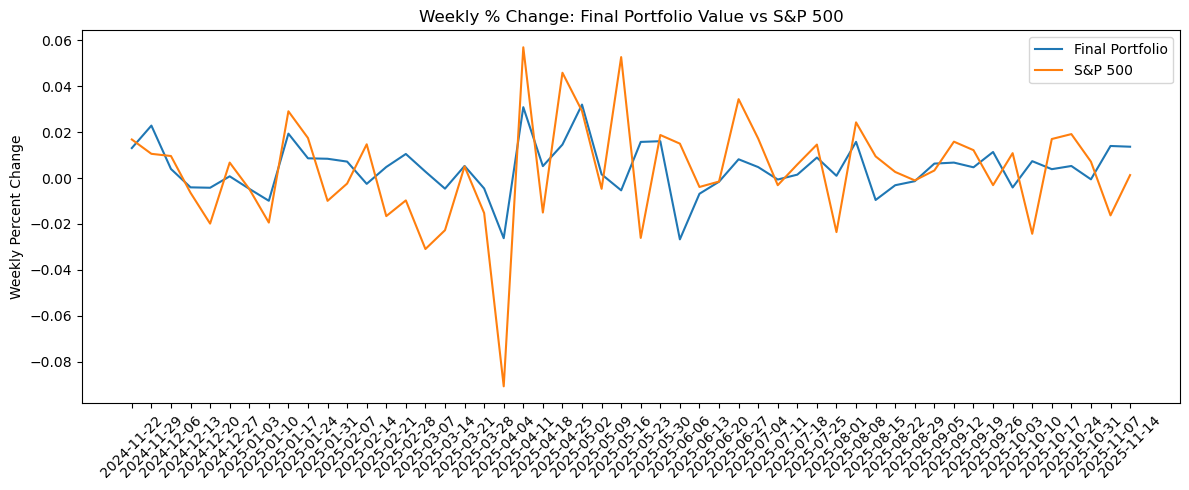

In [21]:
def plot_portfolio_vs_sp500(Portfolio_Final, start_date, end_date):
    """
    Here we are plotting weekly percent change of the total final-portfolio value
    vs weekly percent change of the S&P 500 (^GSPC).
    """

    #Here we get weekly closing prices for all tickers in the final portfolio
    portfolio_tickers = Portfolio_Final["Ticker"].tolist()
    weekly_closes = get_weekly_closes(portfolio_tickers, start_date, end_date)

    #Here we are renaming columns from "Close ..." -> "..." so basically getting ticker symbols
    cleaned_cols = []
    for col in weekly_closes.columns:
        name_str = str(col)
        # "Close " is 6 characters long
        if len(name_str) > 6 and name_str[0:6] == "Close ":
            name_str = name_str[6:]
        cleaned_cols.append(name_str)
    weekly_closes.columns = cleaned_cols   
    #Now collums are ticker symbols

    #Here we are lining up the shares with the price columns
    ticker_shares = Portfolio_Final.set_index("Ticker")["Shares"]
    weekly_closes = weekly_closes[ticker_shares.index]

    #Calcualting the total portfolio value each week
    weekly_portfolio_value = (weekly_closes * ticker_shares).sum(axis=1)

    #Calculating Weekly percent change of portfolio value
    weekly_portfolio_return = weekly_portfolio_value.pct_change()

    #Here we are extracting the weekly closes for S&P 500 using a function defined above
    sp_weekly = get_weekly_closes(["^GSPC"], start_date, end_date)
    sp_col_name = sp_weekly.columns[0]
    sp_weekly_close = sp_weekly[sp_col_name]

    #Calcualting the weekly percent change of the S&P 500 stock
    weekly_sp_return = sp_weekly_close.pct_change()

    #Here I am combining both series and dropping weeks where 1 is missing
    combined = pd.DataFrame({
        "Final_Portfolio": weekly_portfolio_return,
        "SP500": weekly_sp_return
    }).dropna()

    #Plotting both lines for our portfolio, and the S&P 500
    plt.figure(figsize=(12,5))
    plt.plot(combined.index, combined["Final_Portfolio"], label="Final Portfolio")
    plt.plot(combined.index, combined["SP500"], label="S&P 500")

    plt.ylabel("Weekly Percent Change")
    plt.title("Weekly % Change: Final Portfolio Value vs S&P 500")
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_portfolio_vs_sp500(Portfolio_Final, returns_start, returns_end)

Standard Deviation of Weekly Returns:
Final Portfolio:0.01
S&P 500:0.02


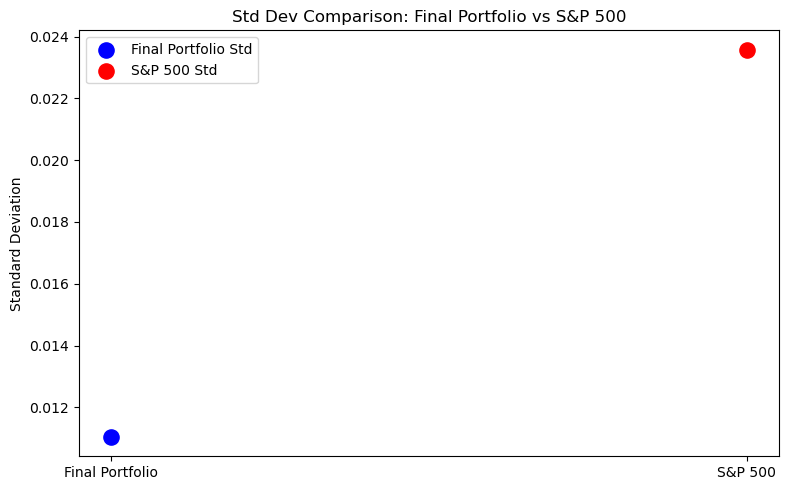

In [24]:
#This function comapres the std of our final portfolio and the S&P 500

def plot_std_scatter_portfolio_vs_sp500(Portfolio_Final, start_date, end_date):
    #Here we are get weekly closes for the final portfolio
    portfolio_tickers = Portfolio_Final["Ticker"].tolist()
    weekly_closes = get_weekly_closes(portfolio_tickers, start_date, end_date)

    # Clean "Close ..." column names
    cleaned_cols = []
    for col in weekly_closes.columns:
        name_str = str(col)
        if len(name_str) > 6 and name_str[:6] == "Close ":
            name_str = name_str[6:]
        cleaned_cols.append(name_str)
    weekly_closes.columns = cleaned_cols

    #Aligning shares with price columns
    ticker_shares = Portfolio_Final.set_index("Ticker")["Shares"]
    weekly_closes = weekly_closes[ticker_shares.index]

    #Getting the weekly portfolio value
    weekly_portfolio_value = (weekly_closes * ticker_shares).sum(axis=1)

    #Getting the weekly % returns
    weekly_portfolio_return = weekly_portfolio_value.pct_change()

    #Here we are getting S&P 500 data to calcualte std later
    sp_weekly = get_weekly_closes(["^GSPC"], start_date, end_date)
    sp_col_name = sp_weekly.columns[0]
    sp_weekly_close = sp_weekly[sp_col_name]

    #Getting the weekly % returns for SP500
    weekly_sp_return = sp_weekly_close.pct_change()

    #Now we combine both return series
    combined = pd.DataFrame({
        "Final_Portfolio": weekly_portfolio_return,
        "SP500": weekly_sp_return
    }).dropna()

    #Here we are calcualting the Std Dev for both final portoflio and sp500
    portfolio_std = combined["Final_Portfolio"].std()
    sp500_std = combined["SP500"].std()

    print("Standard Deviation of Weekly Returns:")
    print(f"Final Portfolio:{portfolio_std:.2f}")
    print(f"S&P 500:{sp500_std:.2f}")

    #Scatter Plot
    plt.figure(figsize=(8, 5))

    plt.scatter(["Final Portfolio"], [portfolio_std], color="blue", s=120, label="Final Portfolio Std")
    plt.scatter(["S&P 500"], [sp500_std], color="red", s=120, label="S&P 500 Std")

    plt.ylabel("Standard Deviation")
    plt.title("Std Dev Comparison: Final Portfolio vs S&P 500")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_std_scatter_portfolio_vs_sp500(Portfolio_Final, returns_start, returns_end)

## Contribution Declaration

The following team members made a meaningful contribution to this assignment:

Neil Zhang, Rahim Rehan, Krish Patel